In [16]:
!pip install -U scikit-learn > None # Restart environment after

In [17]:
!pip install optuna > None

In [28]:
import pandas as pd
import numpy as np
import optuna
import shap

from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [2]:
path = 'https://raw.githubusercontent.com/leomag/music-prediction/main/dataset.csv'

In [3]:
data = pd.read_csv(path, index_col='Unnamed: 0')


In [4]:
df = data.copy().dropna()


In [5]:
cat_cols = df.select_dtypes(include='object')


In [6]:
if 1:
    le = LabelEncoder()
    for c in cat_cols.columns:
        df[c] = le.fit_transform(cat_cols[c])
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,62845,10357,8100,11741,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0
1,55667,3287,14796,22528,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0
2,19766,12397,39162,60774,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0
3,77941,14839,8580,9580,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0
4,68241,5255,16899,25689,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='track_genre'),
    df['track_genre'],
    random_state=2023,
    test_size=0.3
)
X_train.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
20911,9130,28517,5698,67208,72,185194,False,0.628,0.737,7,-4.437,1,0.0410,0.0625,0.000000,0.0777,0.5920,91.507,4
46954,66339,27520,6518,9132,16,137919,False,0.687,0.904,6,-4.208,1,0.4540,0.1180,0.000848,0.6460,0.0378,155.059,4
97965,23671,10344,9374,2612,43,200746,False,0.804,0.784,7,-5.458,1,0.0677,0.2500,0.000000,0.0466,0.9750,152.020,4
102199,75230,1883,42047,3837,0,240146,False,0.523,0.322,0,-8.957,1,0.0285,0.5350,0.000000,0.1320,0.3000,126.002,4
104651,4701,23575,36416,35211,40,229213,False,0.601,0.198,1,-9.794,1,0.0280,0.8630,0.000367,0.1070,0.2010,103.800,4


In [8]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [26]:
etc = ExtraTreesClassifier(n_estimators=100)
etc.fit(X_train_scaled, y_train)
y_preds_etc = etc.predict(X_test_scaled)
print(f'RMSE: {mean_squared_error(y_test, y_preds_etc, squared=False)}')

RMSE: 36.09191887648999


In [9]:
rf = RandomForestRegressor(n_estimators=1000, random_state=2023)
rf.fit(X_train_scaled, y_train)
y_preds = rf.predict(X_test_scaled)
print(f'RMSE: {mean_squared_error(y_test, y_preds, squared=False)}')

RMSE: 29.311558561773722


In [10]:
clf = RandomForestClassifier(n_estimators=650)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=650)

Для RandomForestClassifier выставлял n_estimators=50/200 качество было хуже, при увеличении заметно растёт.

In [ ]:
# from sklearn.calibration import CalibratedClassifierCV
#
# clf = RandomForestClassifier(n_estimators=25)
# clf.fit(X_train, y_train)
# cal_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
# cal_clf.fit(X_valid, y_valid)

In [13]:
clf_probs = clf.predict_proba(X_test)
# cal_clf_probs = cal_clf.predict_proba(X_test)

score = log_loss(y_test, clf_probs)
# cal_score = log_loss(y_test, cal_clf_probs)

print("Log-loss of")
print(f" * uncalibrated classifier: {score:.3f}")
# print(f" * calibrated classifier: {cal_score:.3f}")

Log-loss of
 * uncalibrated classifier: 20.388


In [19]:
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = SVC(C=svc_c, gamma="auto")
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=650)

    score = cross_val_score(classifier_obj, X_train_scaled, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

На данном этапе обучение шло долго, часа 3, дошёл до 11 испытания и получил такие результаты:
[I 2023-02-09 22:03:20,124] Trial 10 finished with value: 0.37123272201708074 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 29}. Best is trial 10 with value: 0.37123272201708074 (это вышел лучший результат.

Дальше, память кончилась и ЦП тоже был забит на 100%, повезло, что MacOS не зависает в таких случаях и я смог руками остановить обучение и вытащить крайнее испытание.

Но в целом получилось лучше, чем на baseline, 0.37 > 0.24.

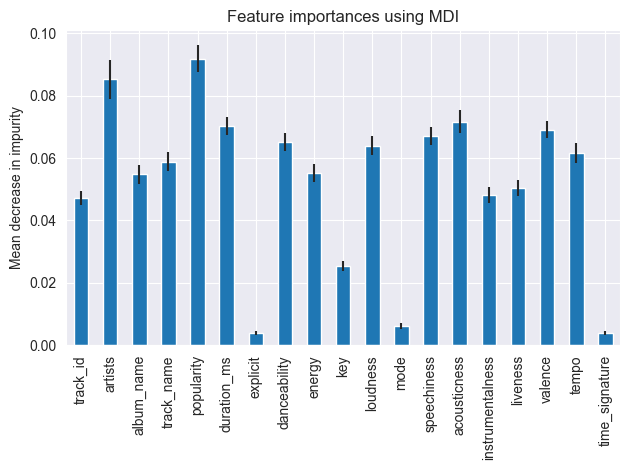

In [21]:
forest_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", )
fig.tight_layout()

На изображение выше можно заметить что три фичи пользы особо не приносят, возможно их можно даже убрать из датасета.
Интересно заметить, что популярность трека сильнее всего влияет на модель. Темп трека и артист тоже высоко, что в целом логично, по артисту можно понять треки в каком жанре он исполняет, да и темпу музыки тоже, тепм музыки напрямую зависит длины трека.
Очень интересно, что даже при плохом качестве логика какая-та в моделе прослеживается.

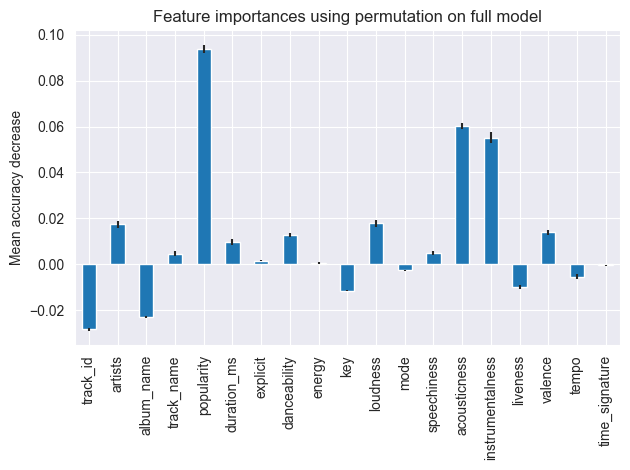

In [24]:
importances = permutation_importance(rf, X_test_scaled, y_test, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Популярность сохранилась, а вот темп упал.

В целом можно сделать вывод, что для данной задачи действительно нужна иерархическая структура (но я не успел до неё добраться) и возможно нейронные сети для обучения на GPU.

In [29]:
explainer = shap.TreeExplainer(rf)

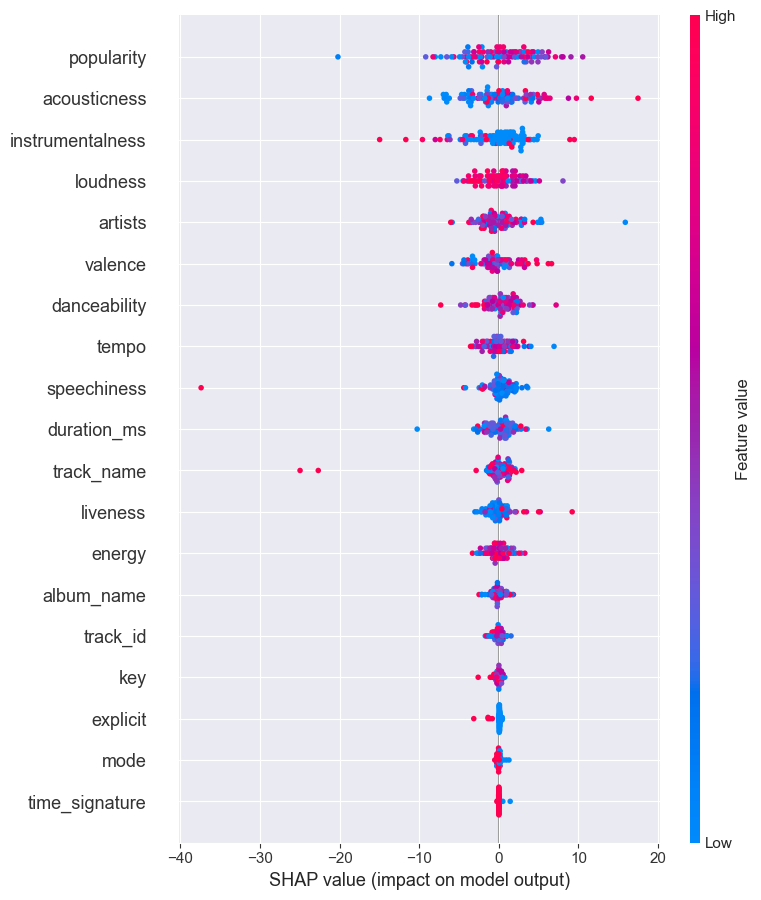

In [30]:
shap_values = explainer.shap_values(X_train_scaled.iloc[:100])
shap.summary_plot(shap_values, X_train_scaled.iloc[:100])

В целом можно сделать вывод, что для данной задачи действительно нужна иерархическая структура (но я не успел до неё добраться) и возможно нейронные сети для обучения на GPU.
Делал это всё на ноутбуке, в колабе сразу память уходила, пытался использовать GradientBoostingClassifier, но даже не дождался его результатов, очень долго, уходил от компьютера, он сам завершал результат и выдавал f1 - 0.42, видать на каком-то промежутке (добавил ниже изображение).

![image](result-gadientboostingclassifier.png)